# A Study of Feature Importance in the Forest Cover Type Prediction Dataset


Data source: https://www.kaggle.com/c/forest-cover-type-prediction

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn import cross_validation
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif 

%matplotlib inline

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data and Remove Useless Columns

In [2]:
forest = pd.read_csv("data/train.csv") 
forest = forest.iloc[:,1:]
#Removal list initialize
to_remove = []
for c in forest.columns:
    if forest[c].std() == 0:
        to_remove.append(c)        
forest.drop(to_remove,axis=1,inplace=True)
print("Dropped the following columns: \n")
for r in to_remove:
    print (r)

Dropped the following columns: 

Soil_Type7
Soil_Type15


### Transform the continuous features
###### We will try Normalization, Standardized Scaling, and MinMax Scaling
###### Note: there is no need to impute any data points as this is a pretty clean data set

In [3]:
num_rows, num_cols = forest.shape
cols = forest.columns

chunk_size = 0.1 #Validation chunk size
size = 10 # First categorical column
seed = 0 # Use the same random seed to ensure consistent validation chunk usage

ranks = [] #array of importance rank of all features
X_all = [] # all features
X_all_add = [] # Additionally we will make a list of subsets
rem = [] # columns to be dropped
i_rem = [] # indexes of columns to be dropped
trans_list = [] # Transformations
comb = [] # combinations
comb.append("All+1.0")

ratio_list = [0.75,0.50,0.25] #Select top 75%, 50%, 25% of features
features = [] # feature selection models
model_features = [] # names of feature selection models

i_cols = []
for i in range(0,num_cols-1):
    i_cols.append(i)

val_array = forest.values
X = val_array[:,0:(num_cols-1)]
y = val_array[:,(num_cols-1)]
X_train, X_val, y_train, y_val = cross_validation.train_test_split(X, y, test_size=chunk_size, random_state=seed)
X_all.append(['Orig','All', X_train,X_val,1.0,cols[:num_cols-1],rem,ranks,i_cols,i_rem])

In [4]:
# Standardize the data

X_temp = StandardScaler().fit_transform(X_train[:,0:size])
X_val_temp = StandardScaler().fit_transform(X_val[:,0:size])

# Recombine data
X_con = np.concatenate((X_temp,X_train[:,size:]),axis=1)
X_val_con = np.concatenate((X_val_temp,X_val[:,size:]),axis=1)

X_all.append(['StdSca','All', X_con,X_val_con,1.0,cols,rem,ranks,i_cols,i_rem])

In [5]:
# MinMax Scale the data

X_temp = MinMaxScaler().fit_transform(X_train[:,0:size])
X_val_temp = MinMaxScaler().fit_transform(X_val[:,0:size])

# Recombine data
X_con = np.concatenate((X_temp,X_train[:,size:]),axis=1)
X_val_con = np.concatenate((X_val_temp,X_val[:,size:]),axis=1)

X_all.append(['MinMax', 'All', X_con,X_val_con,1.0,cols,rem,ranks,i_cols,i_rem])

In [6]:
#Normalize the data

X_temp = Normalizer().fit_transform(X_train[:,0:size])
X_val_temp = Normalizer().fit_transform(X_val[:,0:size])

# Recombine data
X_con = np.concatenate((X_temp,X_train[:,size:]),axis=1)
X_val_con = np.concatenate((X_val_temp,X_val[:,size:]),axis=1)

X_all.append(['Norm', 'All', X_con,X_val_con,1.0,cols,rem,ranks,i_cols,i_rem])

In [7]:
# Add transformation to the list
for trans,name,X,X_val,v,cols_list,rem_list,rank_list,i_cols_list,i_rem_list in X_all:
    trans_list.append(trans)
trans_list

['Orig', 'StdSca', 'MinMax', 'Norm']

### Create the classifiers for measuring importance
- Extra Trees Classifier
- Gradient Boosting Classifier
- Random Forest Classifier
- XGBoost Classifier
- Random Feature Elimination Classifier
- Select Percentile

In [8]:
# Add Extra Trees Classifier
n = 'Extra Trees Classifier'
model_features.append(n)
for val in ratio_list:
    comb.append("%s+%s" % (n,val))
    features.append([n,val,ExtraTreesClassifier(n_estimators=num_cols-1,max_features=val,n_jobs=-1,random_state=seed)])      

# Add Gradient Boosting Classifier
n = 'Gradient Boosting Classifier'
model_features.append(n)
for val in ratio_list:
    comb.append("%s+%s" % (n,val))
    features.append([n,val,GradientBoostingClassifier(n_estimators=num_cols-1,max_features=val,random_state=seed)])   

# Add Random Forest Classifiers
n = 'Random Forest Classifier'
model_features.append(n)
for val in ratio_list:
    comb.append("%s+%s" % (n,val))
    features.append([n,val,RandomForestClassifier(n_estimators=num_cols-1,max_features=val,n_jobs=-1,random_state=seed)])   

# Add XGBoost Classifier
n = 'XGBoost Classifier'
model_features.append(n)
for val in ratio_list:
    comb.append("%s+%s" % (n,val))
    features.append([n,val,XGBClassifier(n_estimators=num_cols-1,seed=seed)])   

# Add RFE
model = LogisticRegression(random_state=seed,n_jobs=-1)
n = 'Random Feature Elimination'
model_features.append(n)
for val in ratio_list:
    comb.append("%s+%s" % (n,val))
    features.append([n,val,RFE(model,val*(num_cols-1))])
    
# Add Select Percentile
n = 'Select Percentile'
model_features.append(n)
for val in ratio_list:
    comb.append("%s+%s" % (n,val))
    features.append([n,val,SelectPercentile(score_func=f_classif,percentile=val*100)])   


### Run All the Models

In [9]:
# Determine feature importance for each model and transformation combination

for trans, s, X, X_val, d, cols, rem, ra, i_cols, i_rem in X_all:
    for name,v, model in features:
        # Train the model against y
        model.fit(X,y_train)

        # Combine importance and index of the column in the array joined
        joined = []
        if name == "Random Feature Elimination":
            for i, pred in enumerate(list(model.ranking_)):
                joined.append([i,cols[i],pred])
        elif name == "Select Percentile":
            for i, pred in enumerate(list(model.scores_)):
                joined.append([i,cols[i],pred])
        else:
            for i, pred in enumerate(list(model.feature_importances_)):
                joined.append([i,cols[i],pred])

        cols_list = [] # List of names of columns selected
        i_cols_list = [] # Indexes of columns selected
        rank_list =[] # Ranking of all the columns
        rem_list = [] # List of columns not selected
        i_rem_list = [] # Indexes of columns not selected

        joined_sorted = sorted(joined, key=lambda x: -x[2]) # Sort in descending order  
        rem_start = int((v*(num_cols-1))) # Starting point of the columns to be dropped

        # Split the array. Store selected columns in cols_list and removed in rem_list
        for j, (i, col, x) in enumerate(list(joined_sorted)):
            rank_list.append([i,j])
            if(j < rem_start):
                cols_list.append(col)
                i_cols_list.append(i)   
            else:
                rem_list.append(col)
                i_rem_list.append(i)

        # Sort the rank_list and store only the ranks. Drop the index 
        # Append model name, array, columns selected and columns to be removed to the additional list        
        X_all_add.append([trans,name,X,X_val,v,cols_list,rem_list,[x[1] for x in sorted(rank_list,key=lambda x:x[0])],i_cols_list,i_rem_list])    

### Plot the results

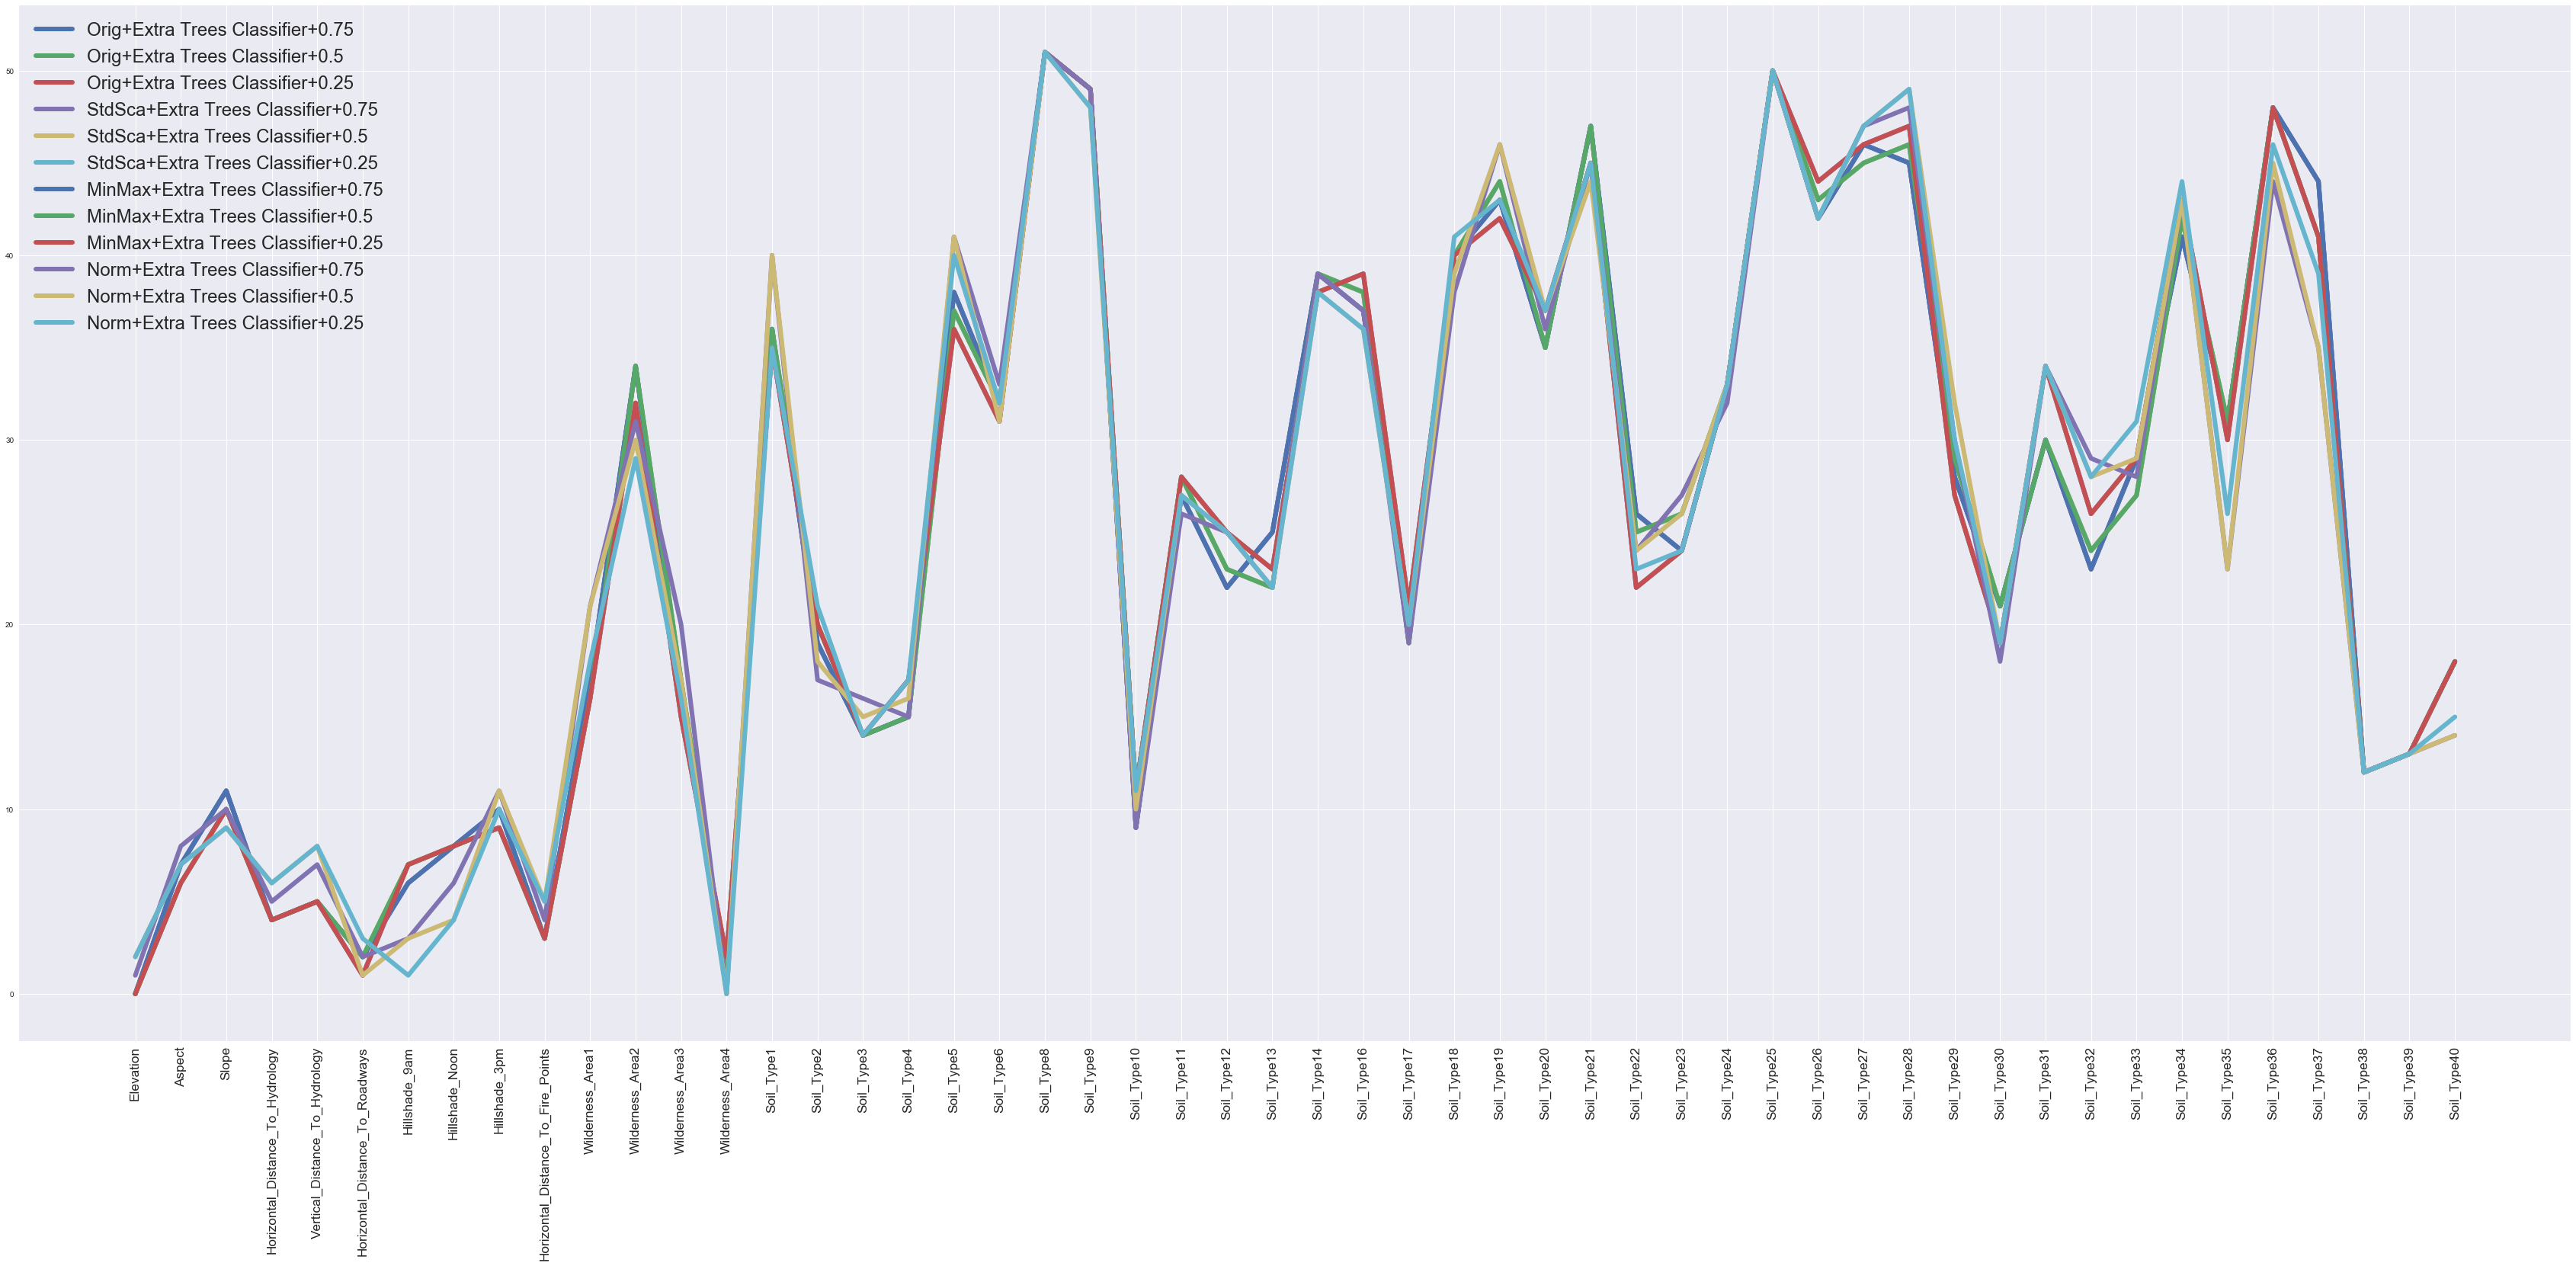

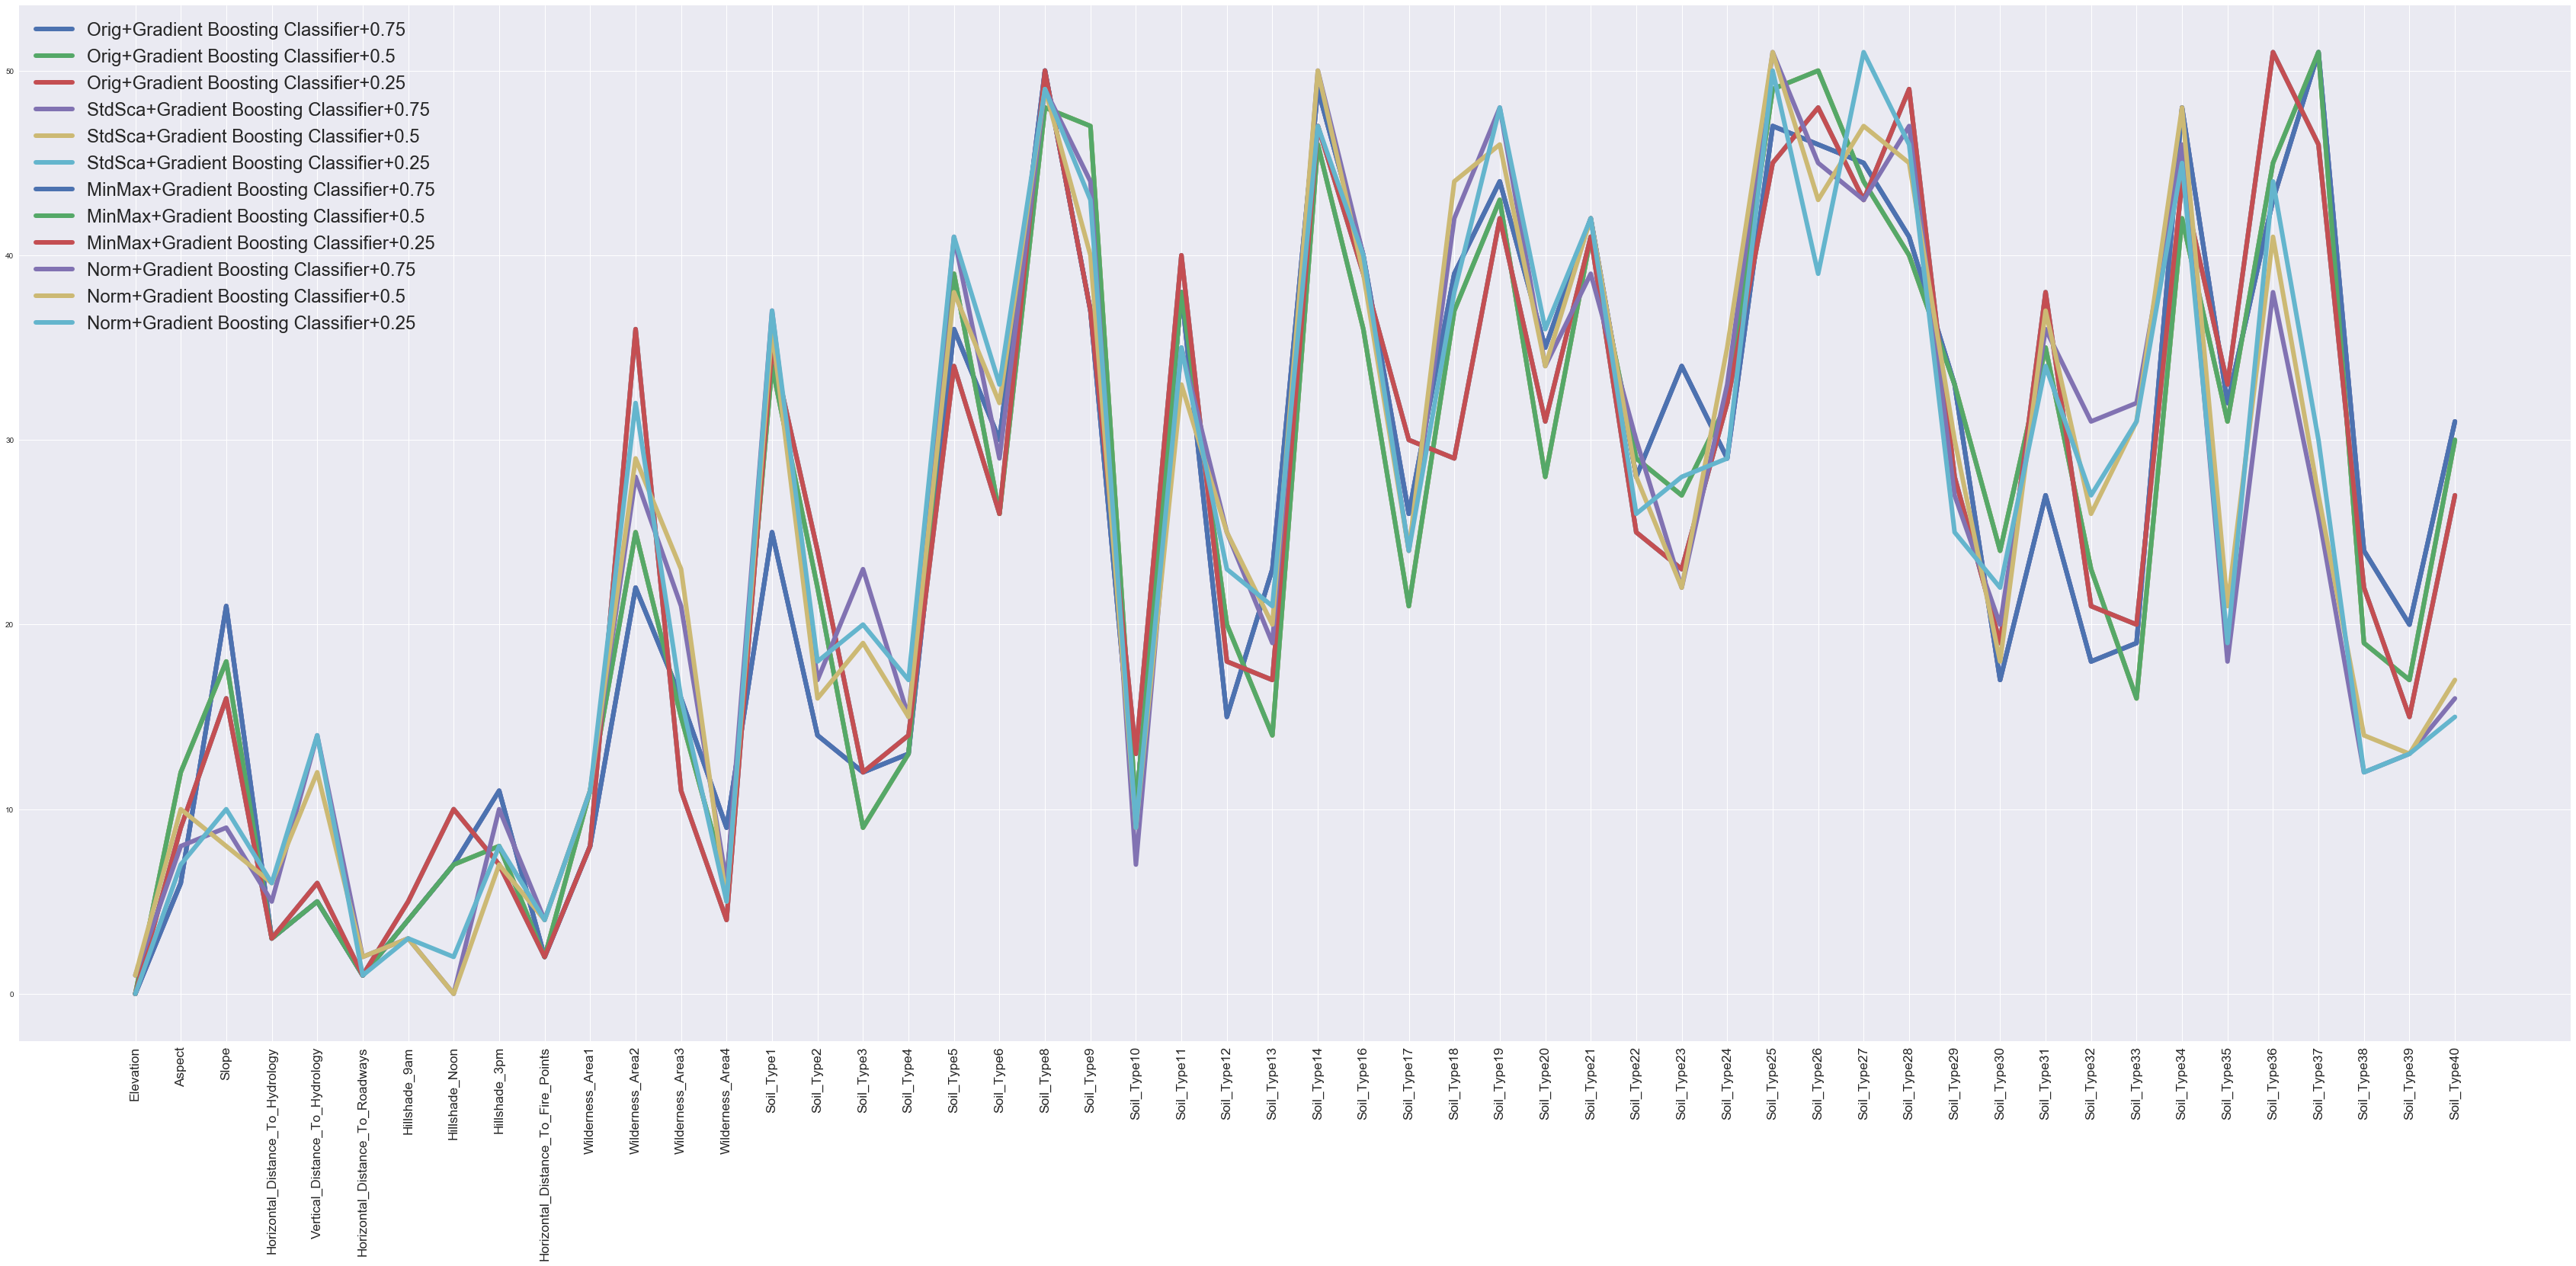

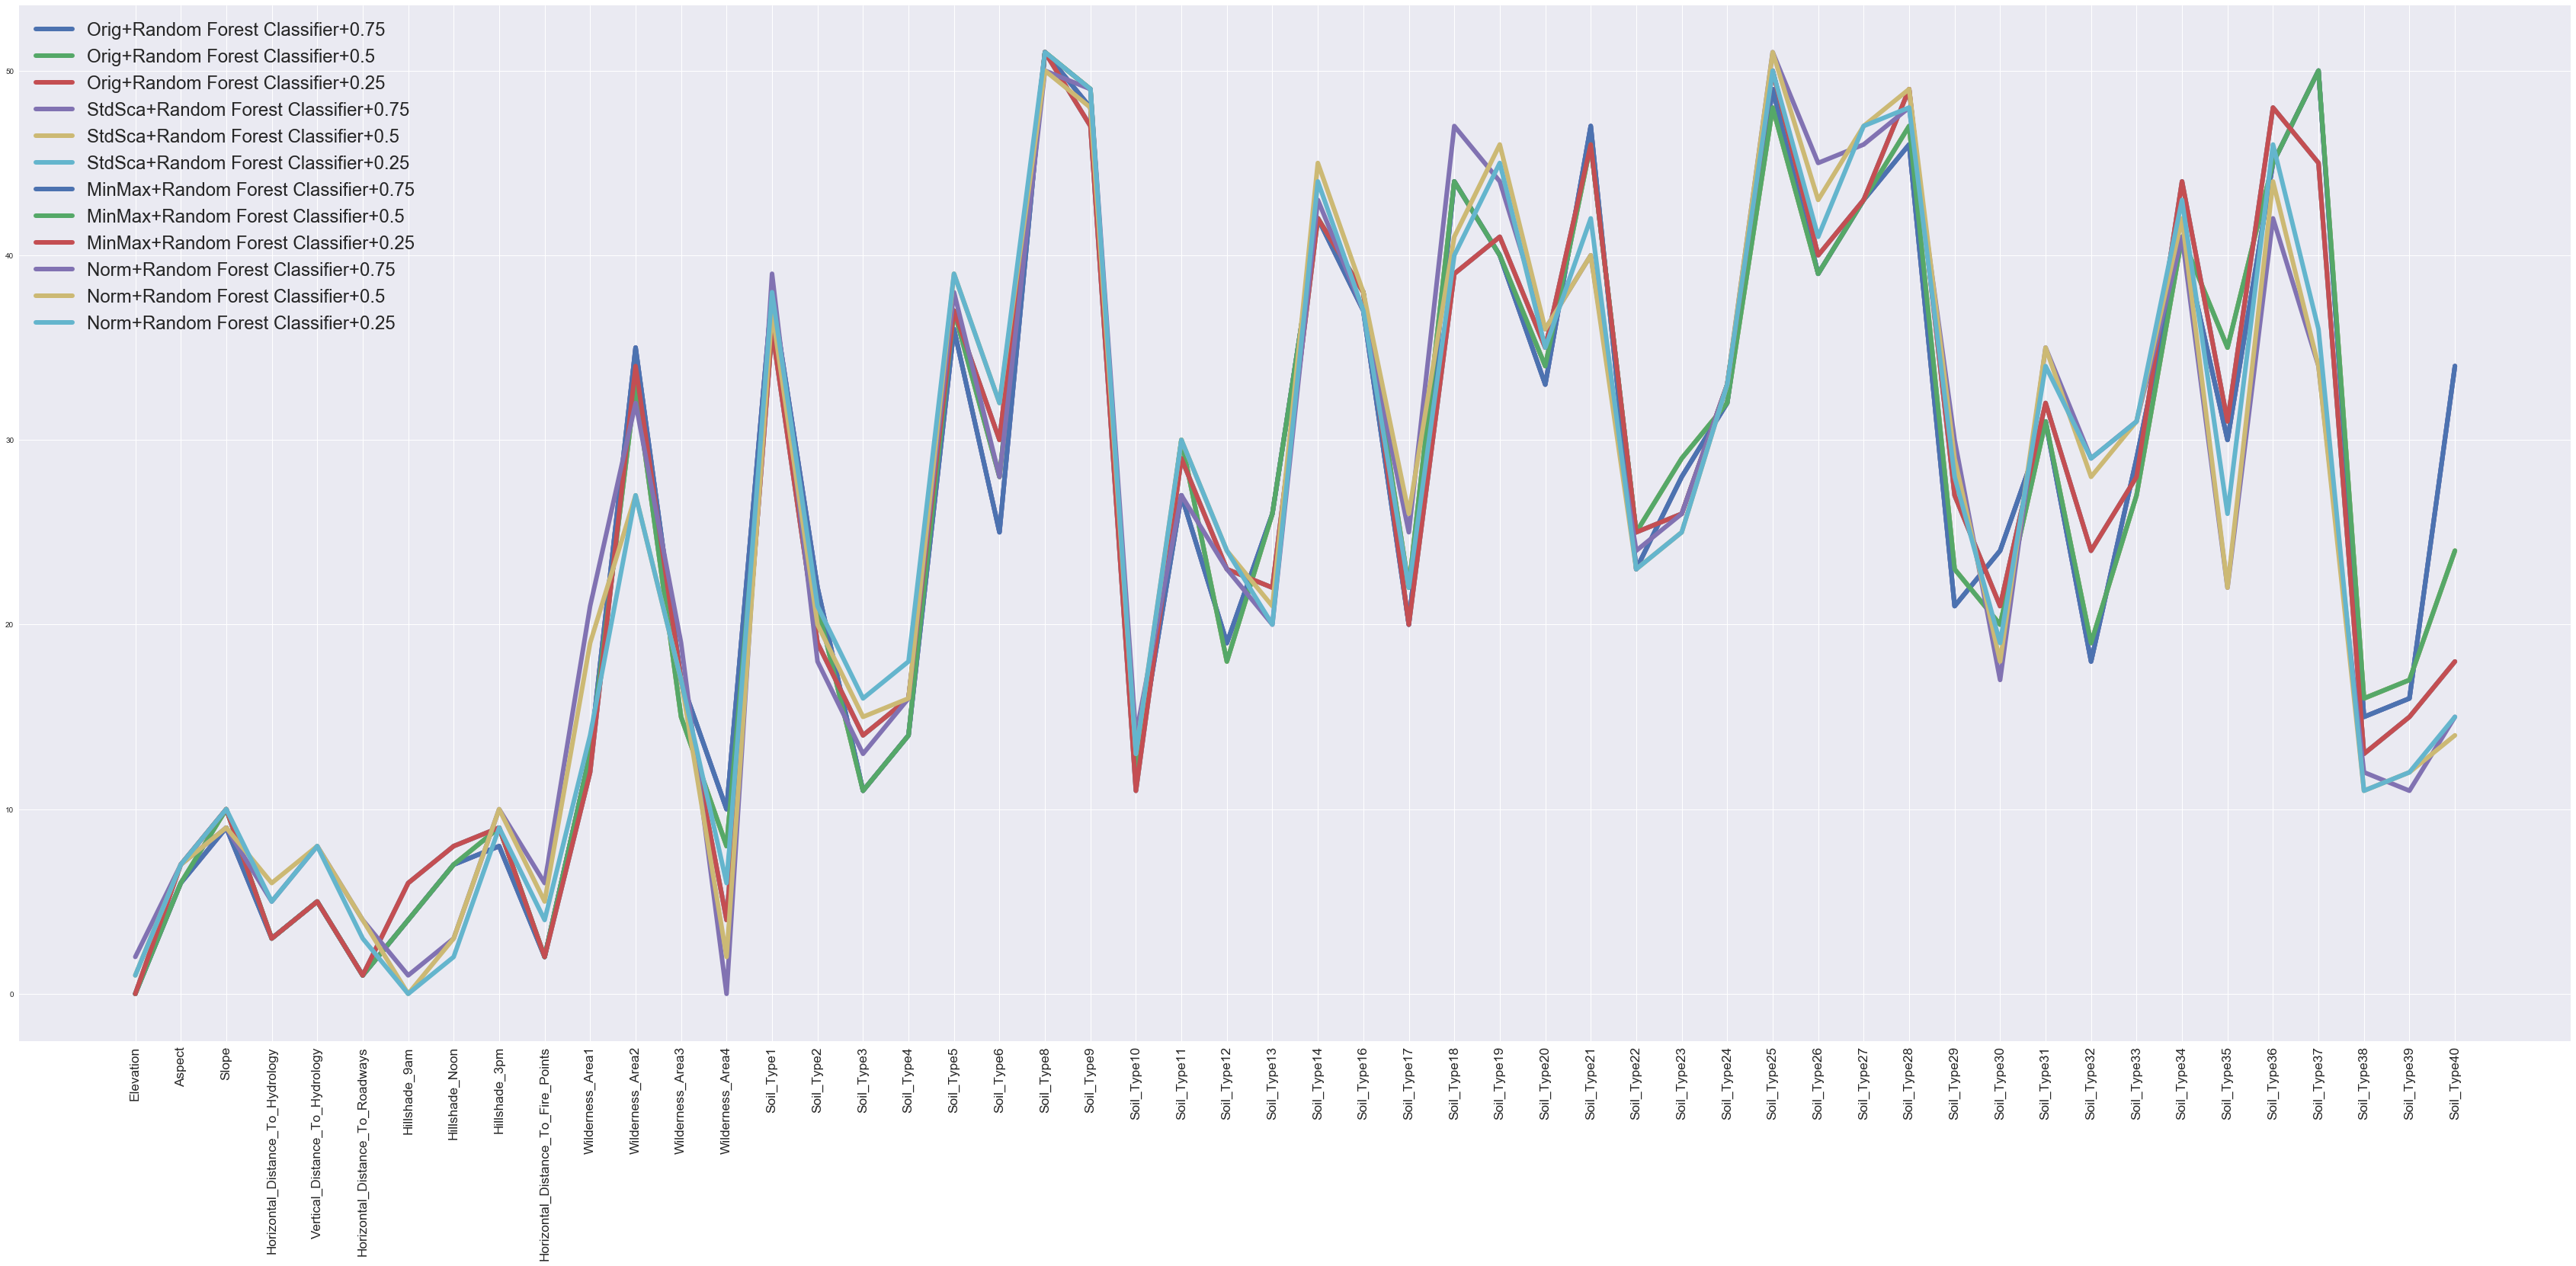

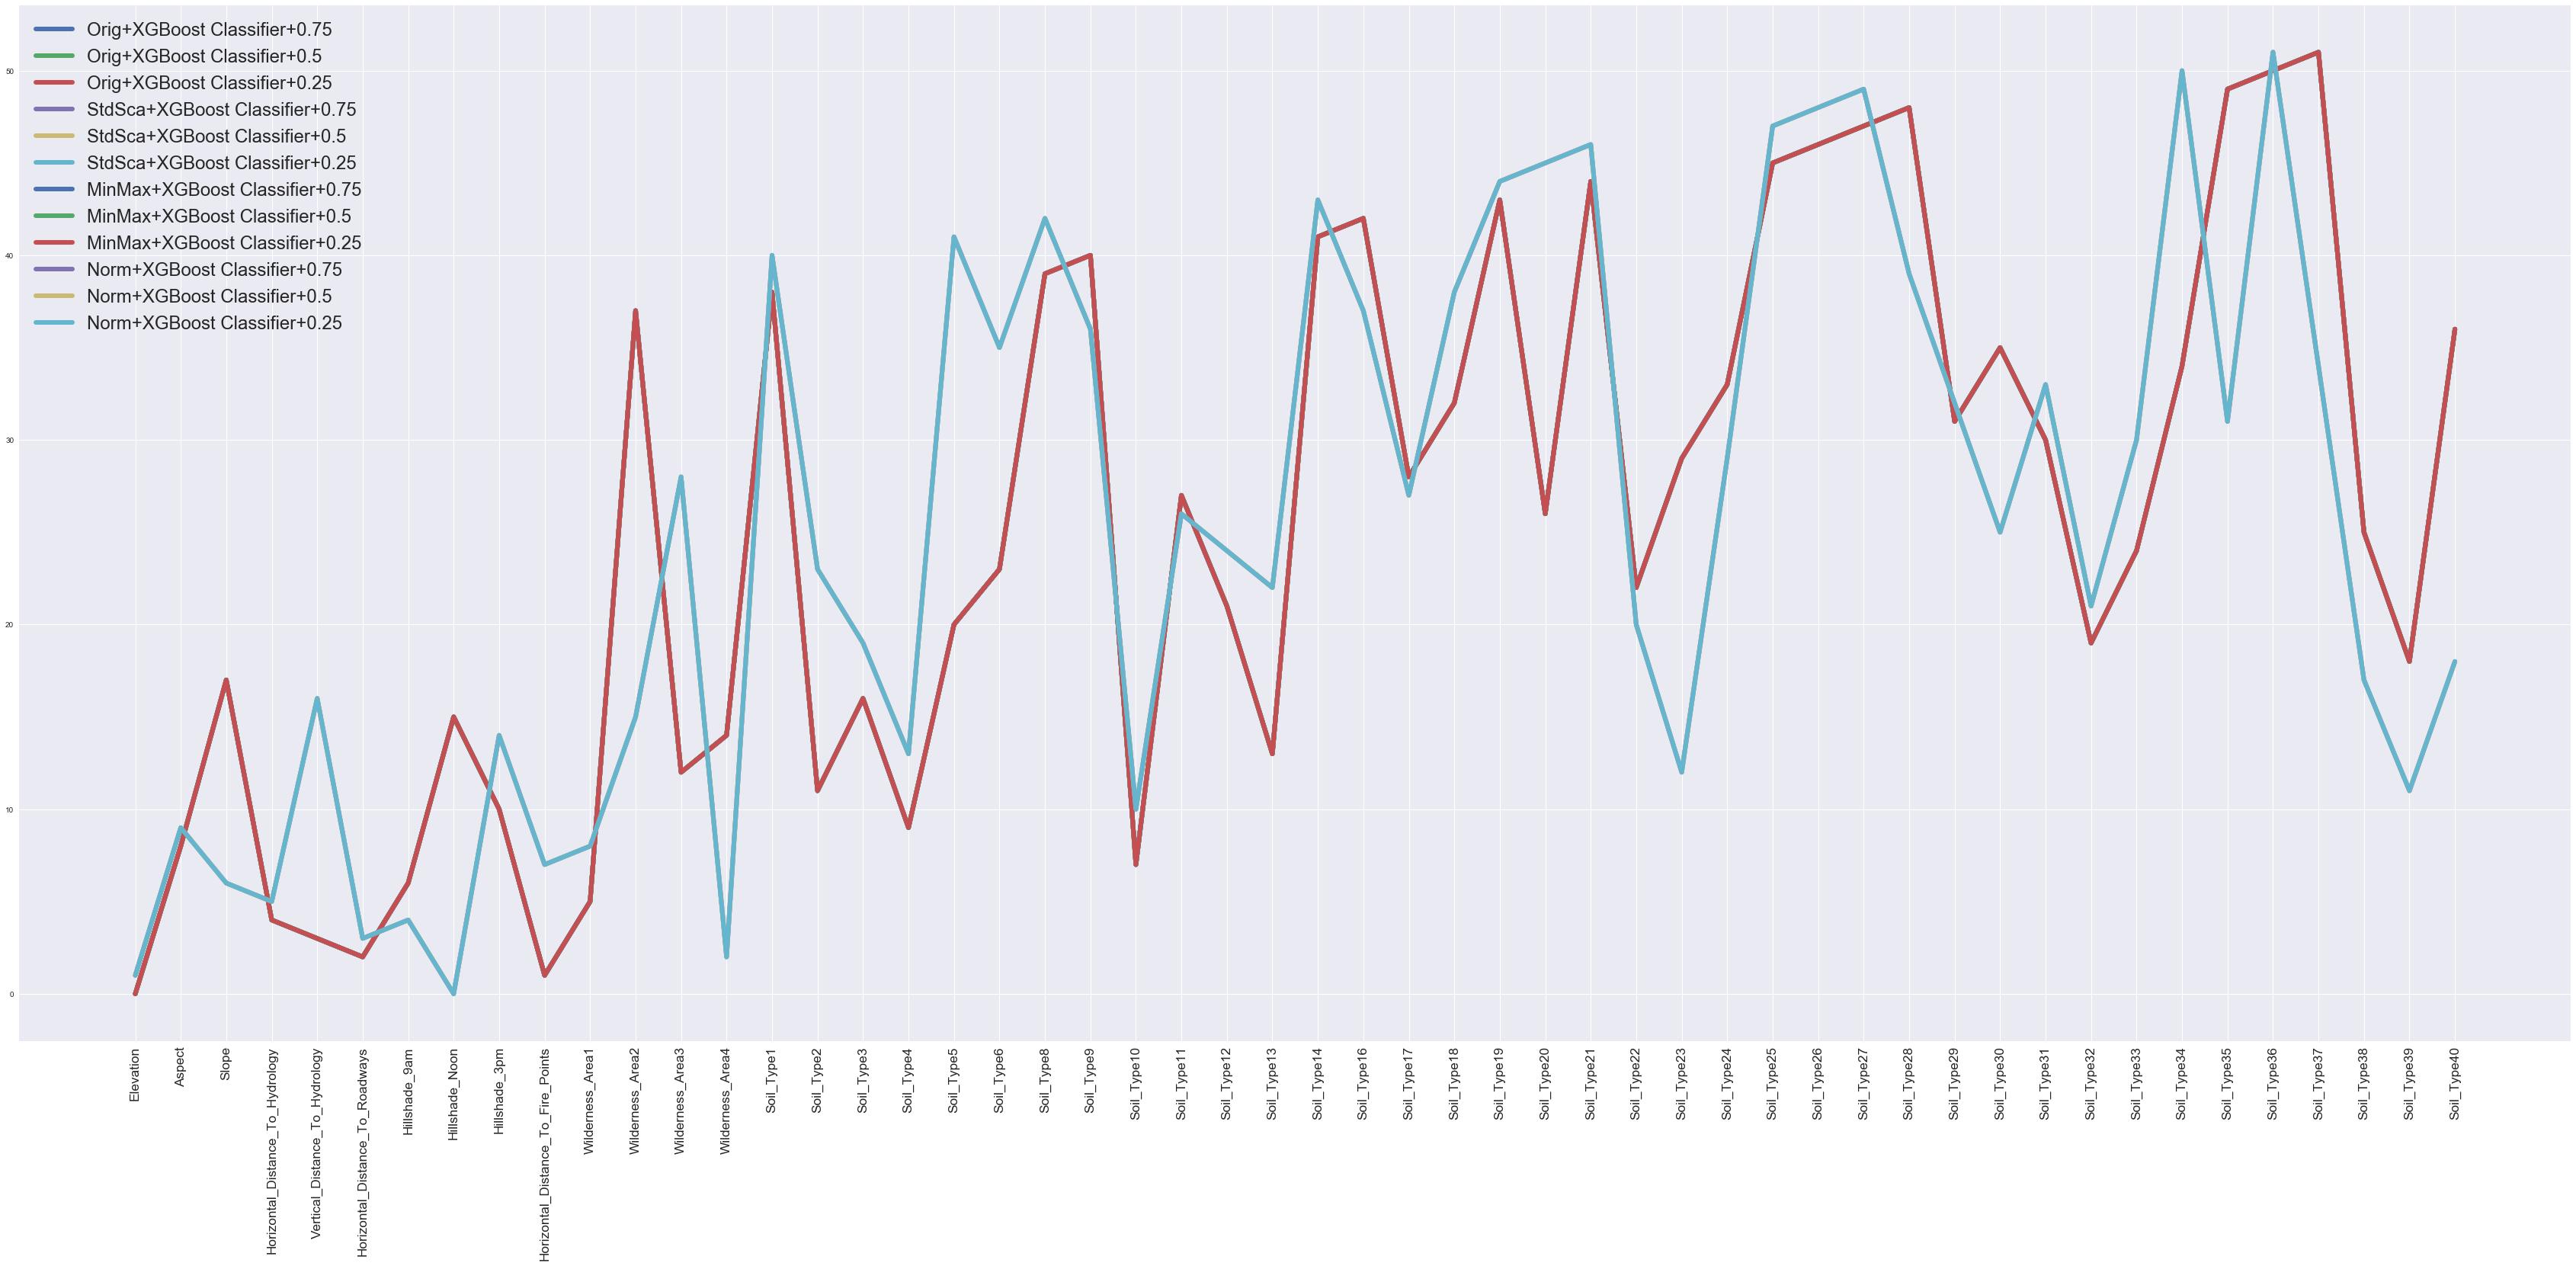

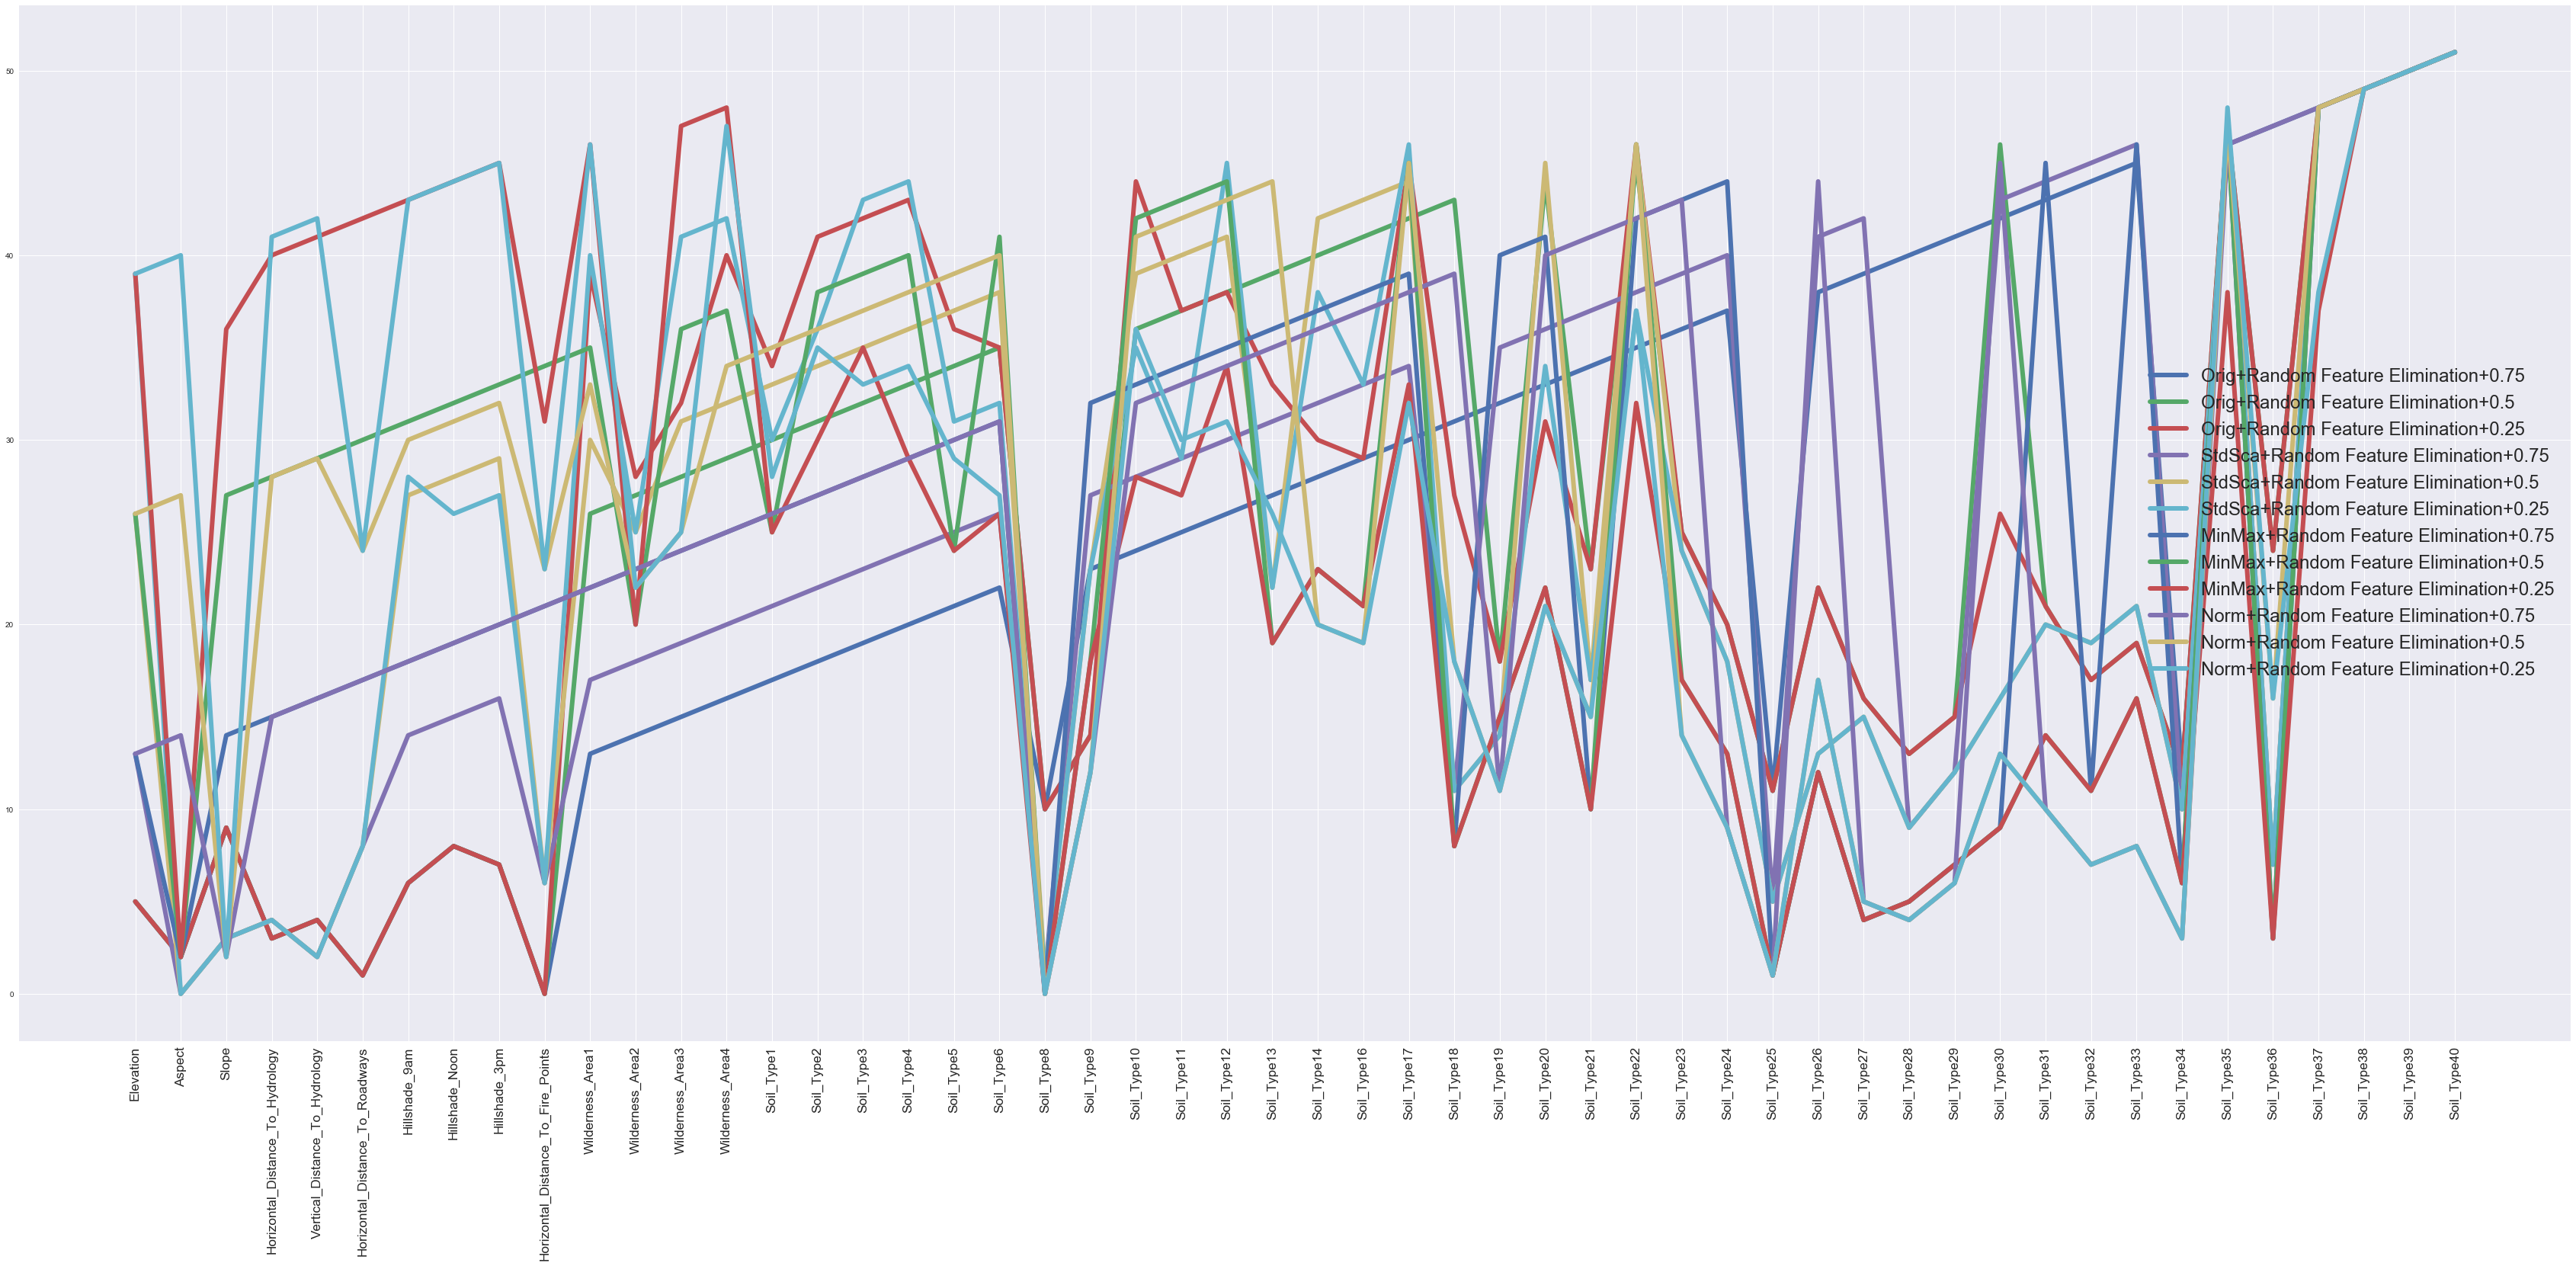

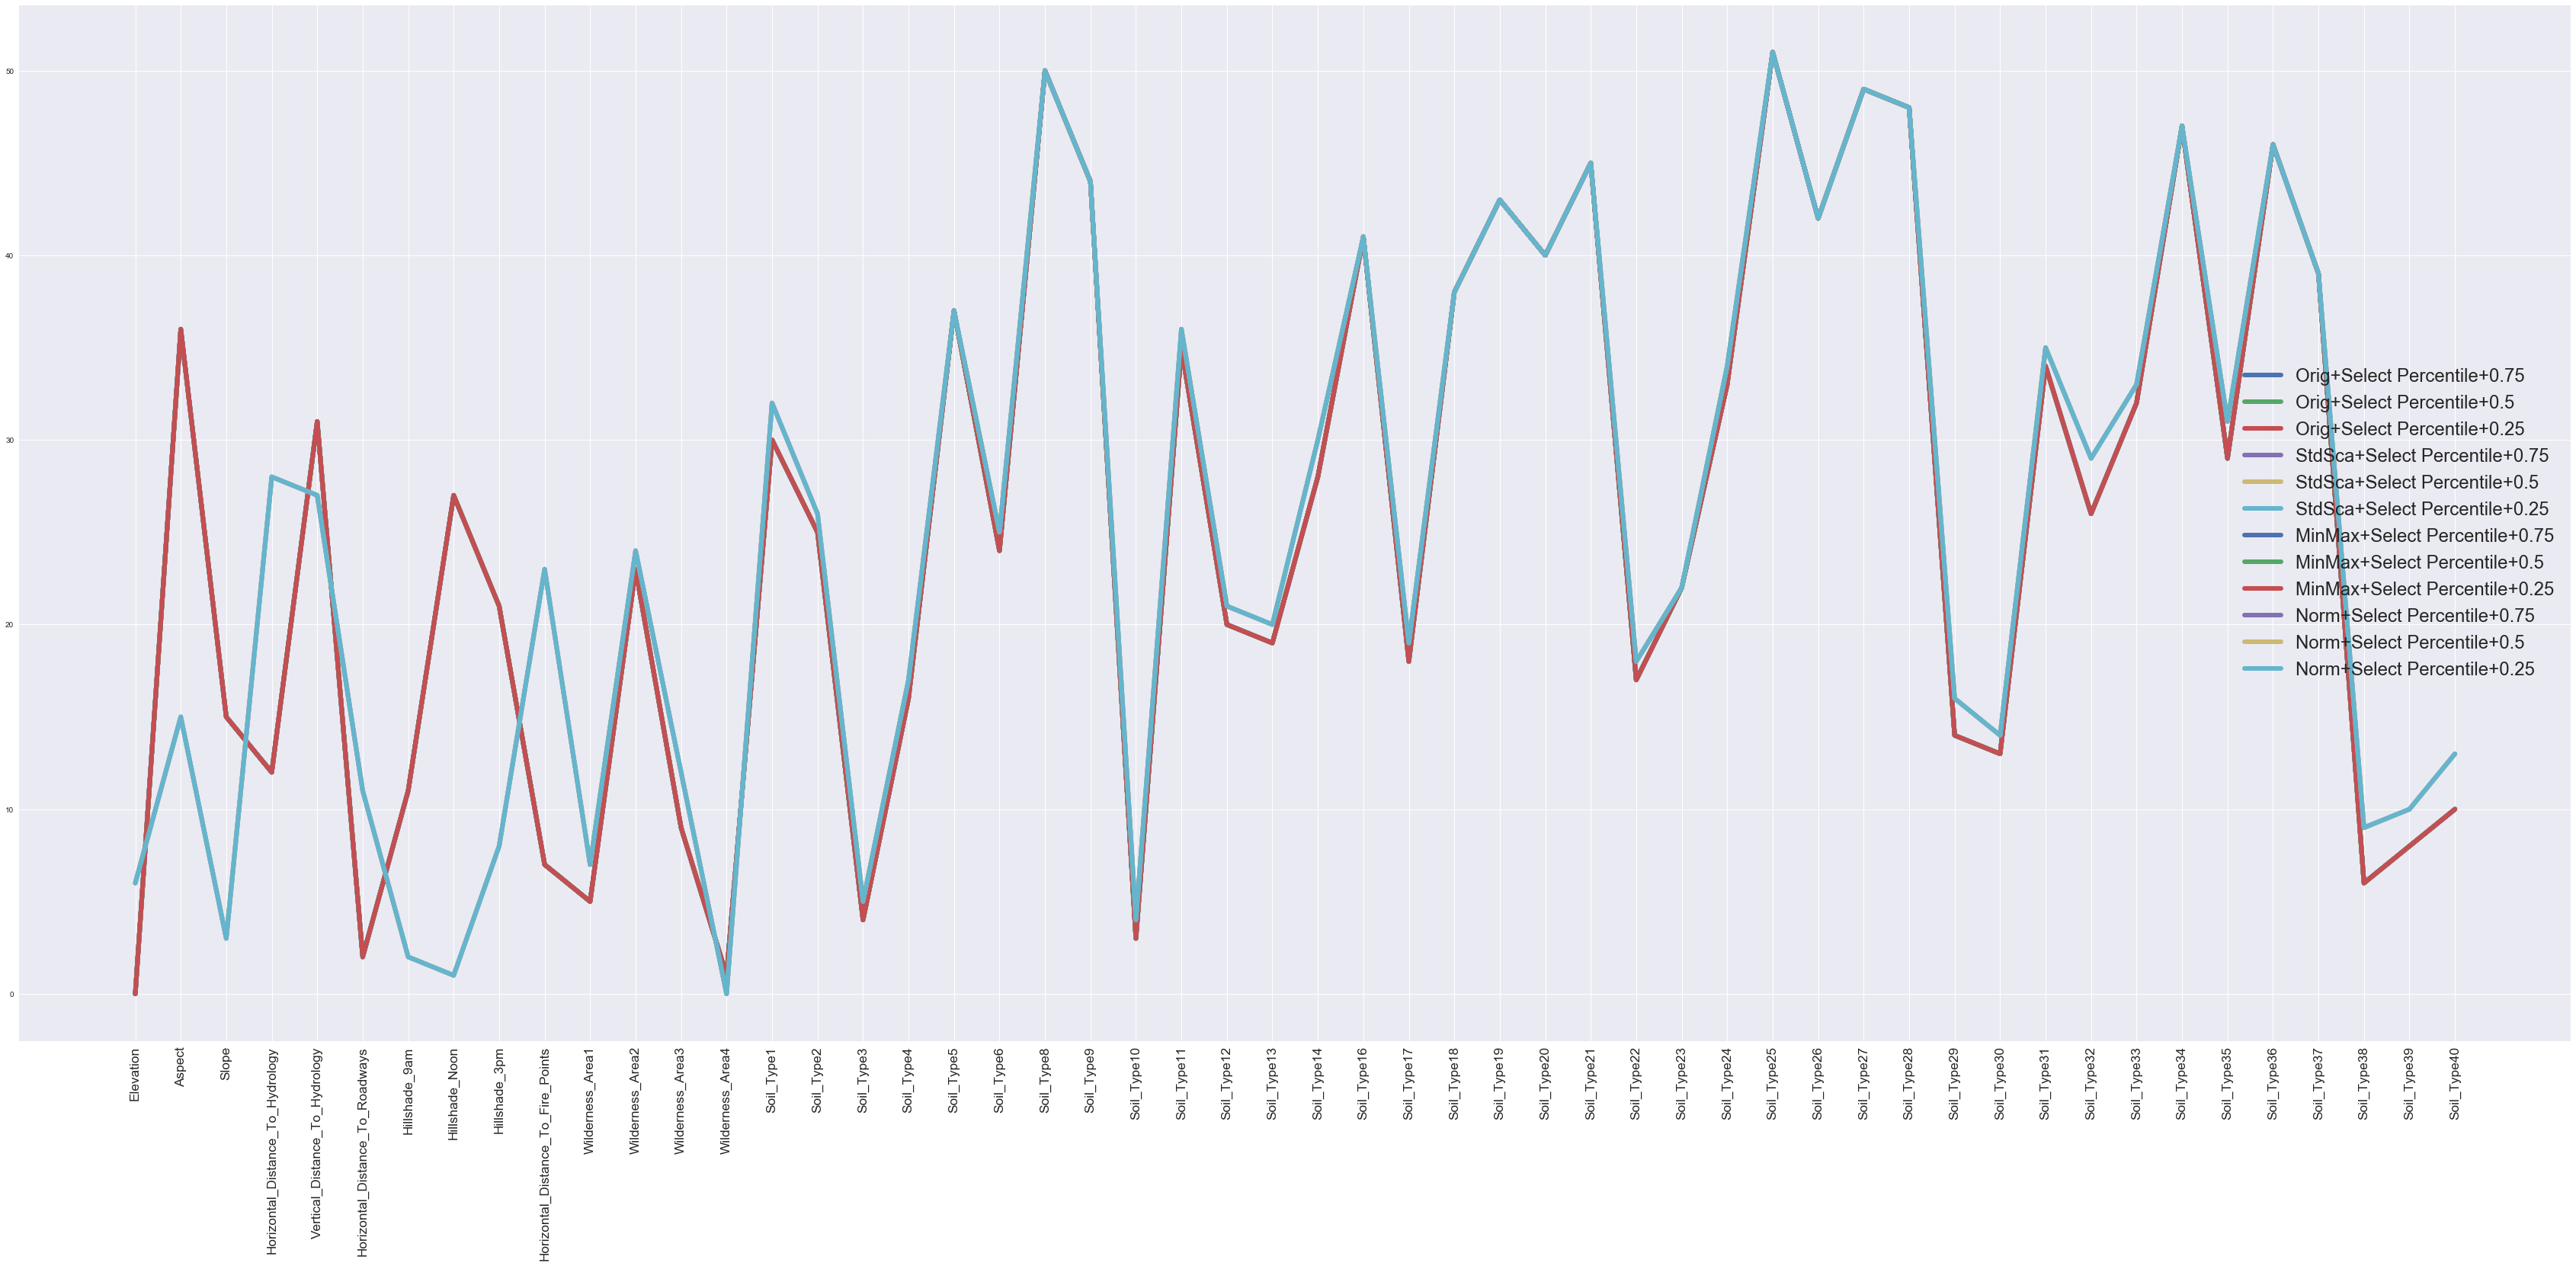

In [11]:
#Set figure size
plt.rc("figure",figsize=(60,25))
#sns.set_context("None")
#Plot a graph for different feature selectors        
for f_name in model_features:
    #Array to store the list of combinations
    leg=[]
    fig, ax = plt.subplots()
    #Plot each combination
    for trans,name,X,X_val,v,cols_list,rem_list,rank_list,i_cols_list,i_rem_list in X_all_add:
        if(name==f_name):
            plt.plot(rank_list, linewidth=6)
            leg.append(trans+"+"+name+"+%s"% v)
            #plt.title(name,size=32)
            
    #Set the tick names to names of columns
    ax.set_xticks(range(num_cols-1))
    ax.set_xticklabels(cols[:num_cols-1],rotation='vertical', size='xx-large')
    #Display the plot
    plt.legend(leg,loc='best',prop={'size':24})    
    #Plot the rankings of all the features for all combinations
    fname = str('visualizations/' + f_name + '_feautre_importance.png')
    plt.savefig(fname)
    plt.show()

## Select the Important Features

In [67]:
# CHECK GITHUB FOR PROPER CREATION OF DF
rank_df = pd.DataFrame(data=[x[7] for x in X_all_add],columns=cols[:num_cols-1])
rank_median = rank_df.median()
rank_median.sort()
rank_df = rank_df[rank_median.index.values.tolist()]

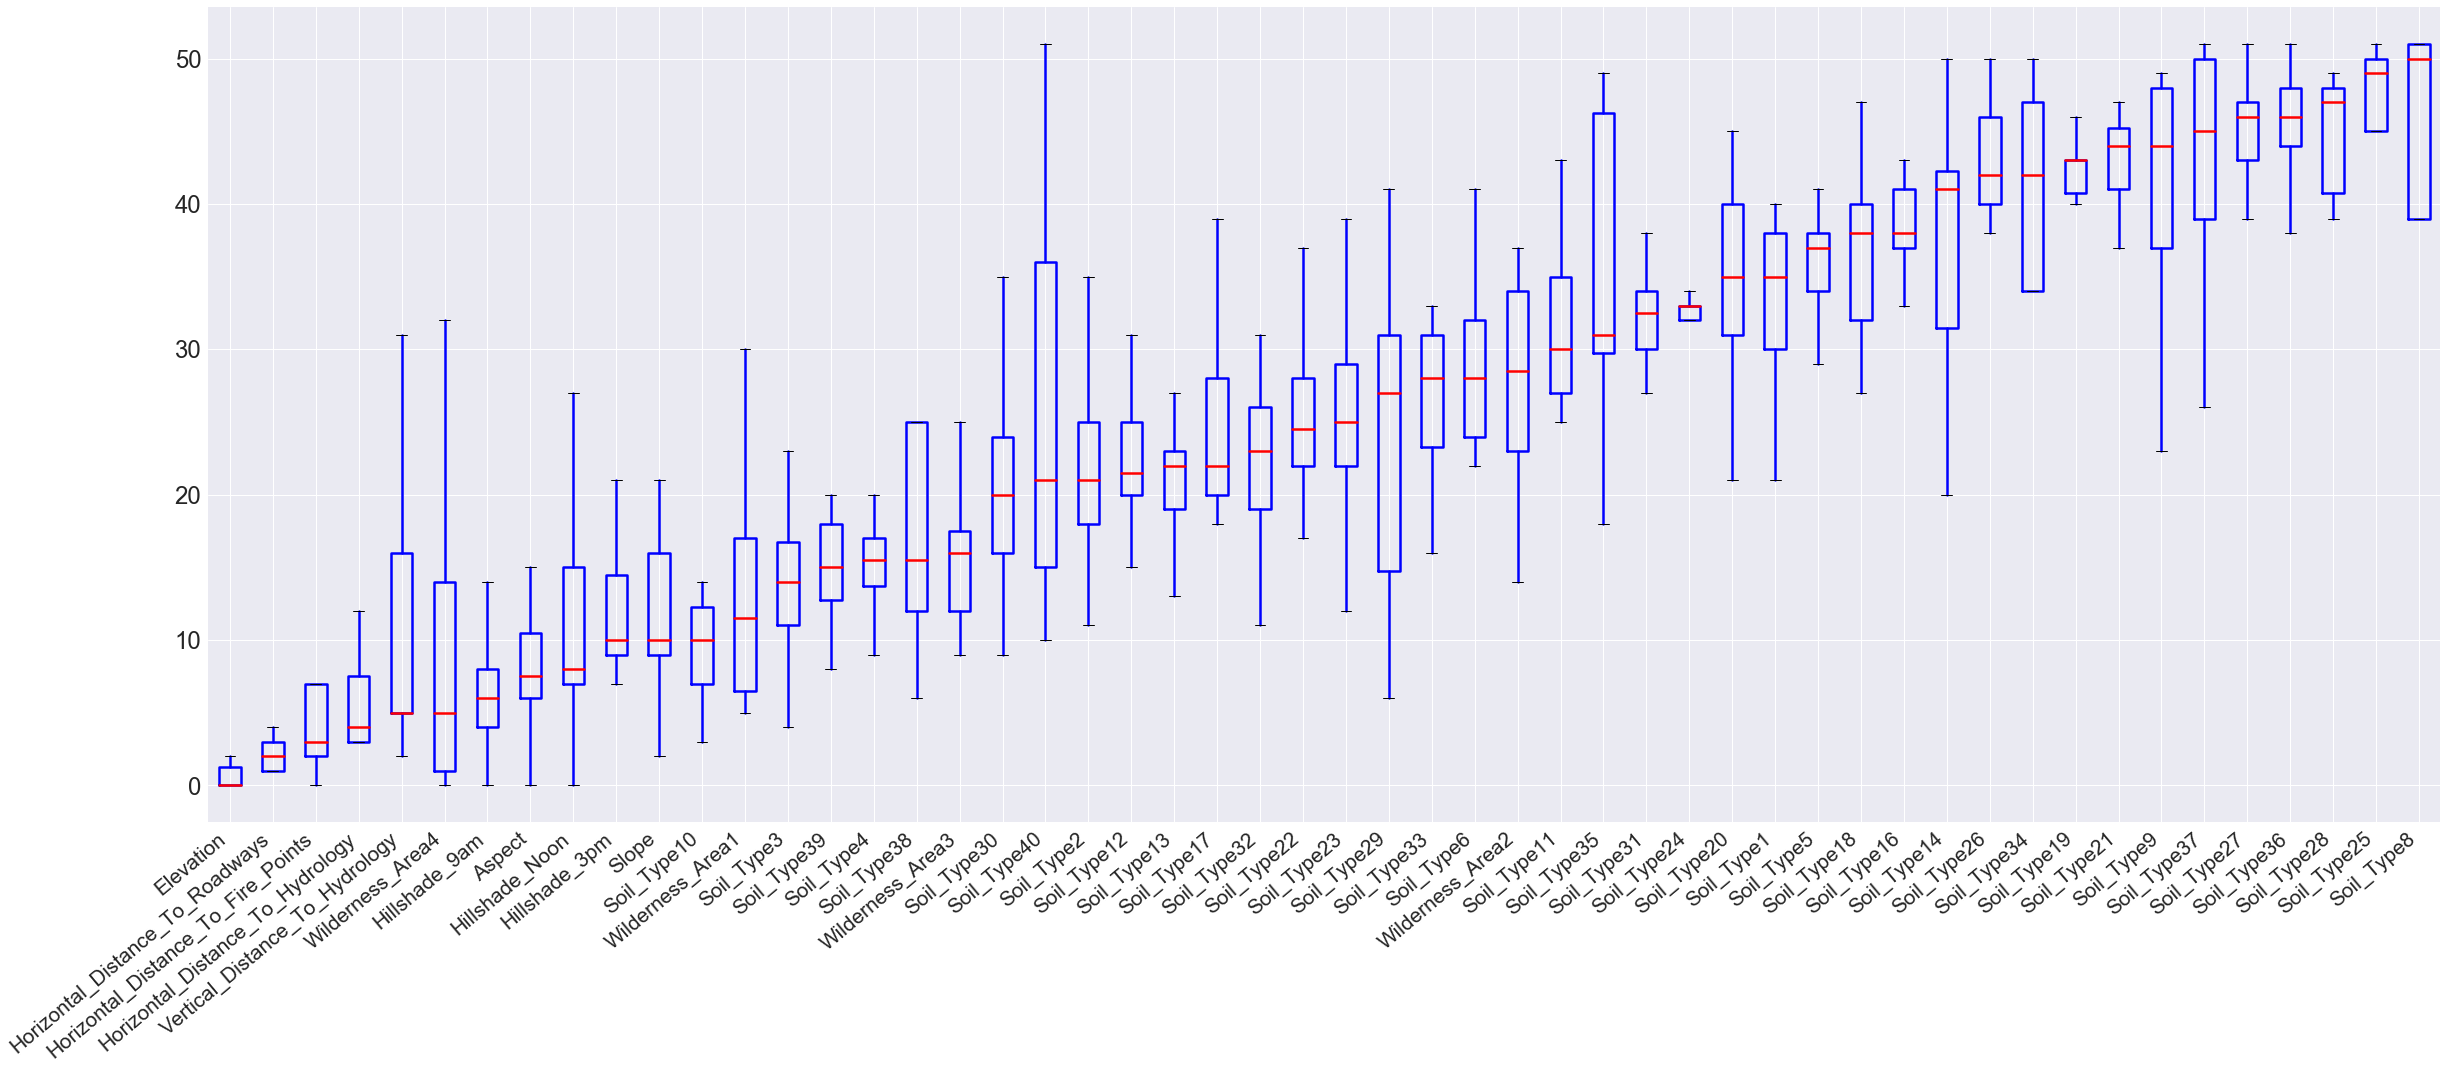

In [71]:
fig = plt.figure(1,figsize=(40,15))
plt.rcParams['ytick.labelsize'] = 24
ax = fig.add_subplot(111)
bp = ax.boxplot(rank_df.values)
ax.set_xticklabels(rank_df.columns.tolist(), rotation=40, ha='right', size='xx-large')
for box in bp['boxes']:
    box.set(color='blue', linewidth=2.5)
for whisker in bp['whiskers']:
    whisker.set(color='blue', linewidth=2.5)
for median in bp['medians']:
    median.set(color='red', linewidth=2.5)

plt.savefig('visualizations/median_feature_importance.png')    
plt.show()

In [72]:
rank_median

Elevation                              0.0
Horizontal_Distance_To_Roadways        2.0
Horizontal_Distance_To_Fire_Points     3.0
Horizontal_Distance_To_Hydrology       4.0
Vertical_Distance_To_Hydrology         5.0
Wilderness_Area4                       5.0
Hillshade_9am                          6.0
Aspect                                 7.5
Hillshade_Noon                         8.0
Hillshade_3pm                         10.0
Slope                                 10.0
Soil_Type10                           10.0
Wilderness_Area1                      11.5
Soil_Type3                            14.0
Soil_Type39                           15.0
Soil_Type4                            15.5
Soil_Type38                           15.5
Wilderness_Area3                      16.0
Soil_Type30                           20.0
Soil_Type40                           21.0
Soil_Type2                            21.0
Soil_Type12                           21.5
Soil_Type13                           22.0
Soil_Type17